<a href="https://colab.research.google.com/github/akitim/comptech-winter-school-2022_covid19-prediction/blob/main/prepare_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Копия prepare_data в МОЕМ репозитории 

In [24]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 200)

In [2]:
# !mkdir covid19-prediction
!git clone https://github.com/comptech-winter-school/covid19-prediction
!cd covid19-prediction
!git init
!git remote add origin https://github.com/comptech-winter-school/covid19-prediction
!git fetch
!git checkout etl
!cd covid19-prediction
!git pull origin etl

Cloning into 'covid19-prediction'...
remote: Enumerating objects: 375, done.
remote: Counting objects: 100% (375/375), done.
remote: Compressing objects: 100% (236/236), done.
remote: Total 375 (delta 169), reused 208 (delta 61), pack-reused 0
Receiving objects: 100% (375/375), 96.13 MiB | 14.47 MiB/s, done.
Resolving deltas: 100% (169/169), done.
Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 375, done.
remote: Counting objects: 100% (375/375), done.
remote: Compressing objects: 100% (236/236), done.
remote: Total 375 (delta 169), reused 208 (delta 61), pack-reused 0
Receiving objects: 100% (375/375), 96.13 MiB | 13.94 MiB/s, done.
Resolving deltas: 100% (169/169), done.
From https://github.com/comptech-winter-school/covid19-prediction
 * [new branch]      alex          -> origin/alex
 * [new branch]      ci-cd         -> origin/ci-cd
 * [new branch]      documentation -> origin/documentation
 * [new branch]      etl           -> origin/etl
 * [new bra

In [9]:
!git checkout etl

Switched to branch 'etl'
Your branch is up to date with 'origin/etl'.


In [3]:
# !git clone https://github.com/comptech-winter-school/covid19-prediction

In [10]:
!git status

On branch etl
Your branch is up to date with 'origin/etl'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	.config/
	covid19-prediction/
	sample_data/

nothing added to commit but untracked files present (use "git add" to track)


In [36]:
# path = "covid19-prediction"
path = "/content/"
all_files = Path(path).glob("data*.csv") 

df = pd.concat(map(pd.read_csv, all_files));

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# path = "COVID-19/csse_covid_19_data/csse_covid_19_daily_reports"
# all_files = Path(path).glob("*.csv") 

# df = pd.concat(map(pd.read_csv, all_files))

In [12]:
df.shape

(2637010, 22)

In [13]:
df.head()

,Unnamed: 0,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio,Incident_Rate,Case_Fatality_Ratio,Province/State,Country/Region,Last Update,Latitude,Longitude
0,1405,18063.0,Hendricks,Indiana,US,2021-08-01 04:21:50,39.767190,-86.510373,18168.0,323.0,NaN,NaN,"Hendricks, Indiana, US",NaN,NaN,10667.543494,1.777851,NaN,NaN,NaN,NaN,NaN
1,1406,18065.0,Henry,Indiana,US,2021-08-01 04:21:50,39.930290,-85.396257,5971.0,111.0,NaN,NaN,"Henry, Indiana, US",NaN,NaN,12446.843992,1.858985,NaN,NaN,NaN,NaN,NaN
2,1407,18067.0,Howard,Indiana,US,2021-08-01 04:21:50,40.485277,-86.113519,10747.0,237.0,NaN,NaN,"Howard, Indiana, US",NaN,NaN,13019.722814,2.205267,NaN,NaN,NaN,NaN,NaN
3,1408,18069.0,Huntington,Indiana,US,2021-08-01 04:21:50,40.829073,-85.488221,4213.0,82.0,NaN,NaN,"Huntington, Indiana, US",NaN,NaN,11536.144578,1.946357,NaN,NaN,NaN,NaN,NaN
4,1409,18071.0,Jackson,Indiana,US,2021-08-01 04:21:50,38.909158,-86.038519,5186.0,77.0,NaN,NaN,"Jackson, Indiana, US",NaN,NaN,11724.808392,1.484767,NaN,NaN,NaN,NaN,NaN


In [35]:
def merge_columns(f1, f2, df):
    d = df.loc[:, [f1, f2]].copy()
    d.loc[d[f1].isna(), f1] = d.loc[d[f1].isna(), f2]
    return d[f1]

In [26]:
# убираем страны c подтвержденными случаями < 10^5
def remove_small_countries(df):
    countries = df.groupby("Country_Region").last().query('Confirmed > 100000').index.to_list()
    return df[df.Country_Region.isin(countries)]

In [42]:
def add_new_cases(data):

    temp_df, df_ = pd.DataFrame(), pd.DataFrame()
    for country in data['Country_Region'].unique():
        temp_df = data.loc[data['Country_Region'] == country, :].copy()
        temp_df['New_Cases'] = (temp_df['Confirmed'] - temp_df['Confirmed'].shift(1))
        df_ = pd.concat([df_, temp_df], axis=0).dropna()
    
    return df_

In [27]:
def report_shape(df):
    print(df.shape)
    return df

In [43]:
# !mkdir tmp
# data=\
(df
 .assign(Country_Region = merge_columns("Country_Region", "Country/Region", df))
 .assign(Last_Update = merge_columns("Last_Update", "Last Update", df))
 .assign(Last_Update = pd.to_datetime(df["Last_Update"]).dt.date)
 .loc[:, ["Country_Region", "Last_Update", "Confirmed"]]
 .dropna()
 .groupby(["Country_Region", "Last_Update"])
 .sum()
 .reset_index()
 .set_index("Last_Update")
 .sort_index()
 .pipe(remove_small_countries)
 .pipe(add_new_cases)
#  .pipe(report_shape)
 .to_parquet("tmp/data.parquet")
)
data = pd.read_parquet("tmp/data.parquet")

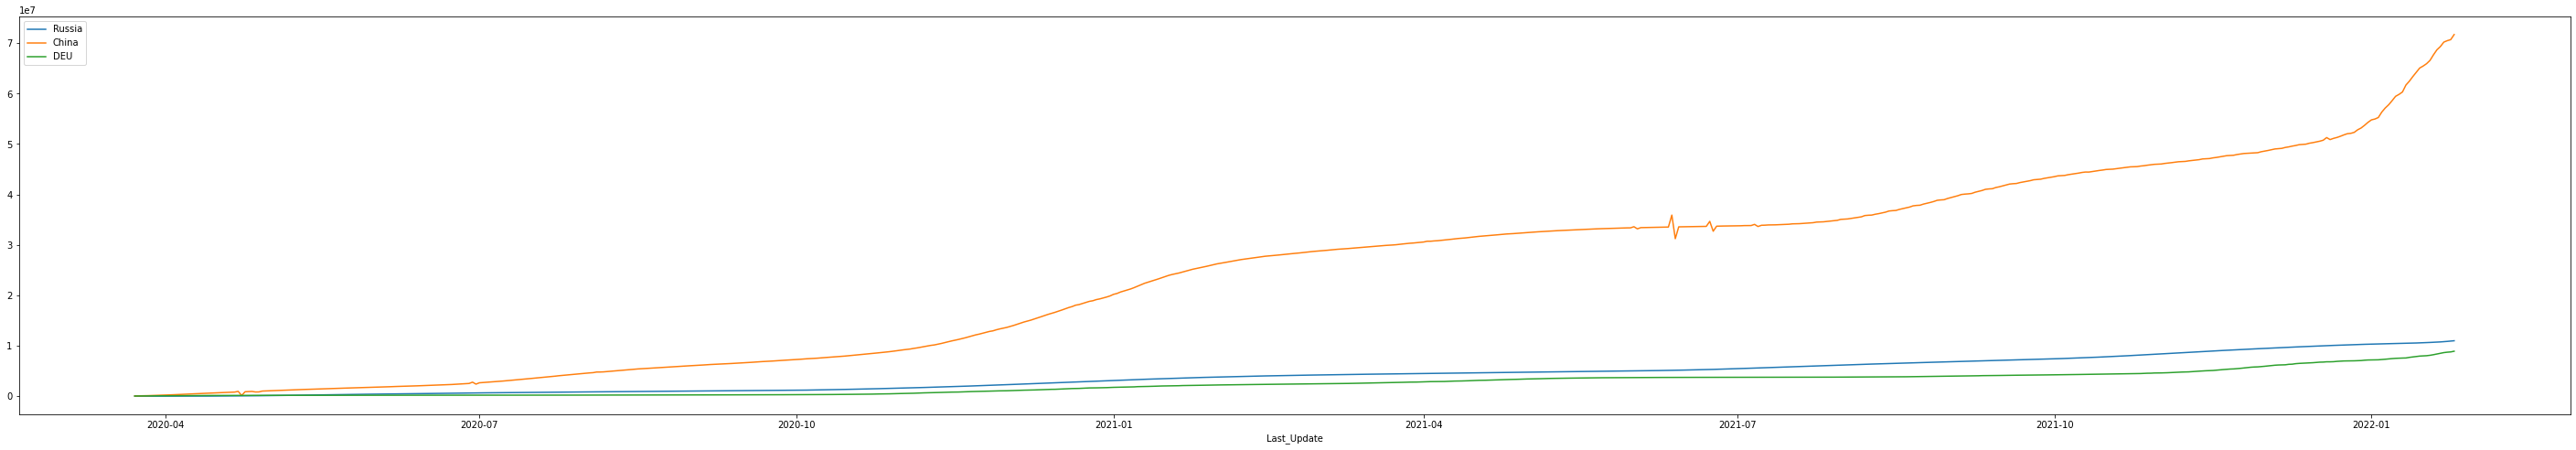

In [49]:
# data.sort_index(ascending=False)
# data.loc[data['New_Cases'] < 0, 'New_Cases'].count() / \
# data.loc[~(data['New_Cases'] < 0), 'New_Cases'].count()
russia_cases = data.loc[data['Country_Region'] == 'Russia', 'Confirmed']
us_cases = data.loc[data['Country_Region'] == 'US', 'Confirmed']
germany_cases = data.loc[data['Country_Region'] == 'Germany', 'Confirmed']
china_cases = data.loc[data['Country_Region'].apply(lambda x: 'China' in x), 'Confirmed']

plt.figure(figsize=(50, 8))
russia_cases.plot(label='Russia');
# us_cases.plot();
us_cases.plot(label='China');
germany_cases.plot(label='DEU');
plt.legend(loc='upper left');

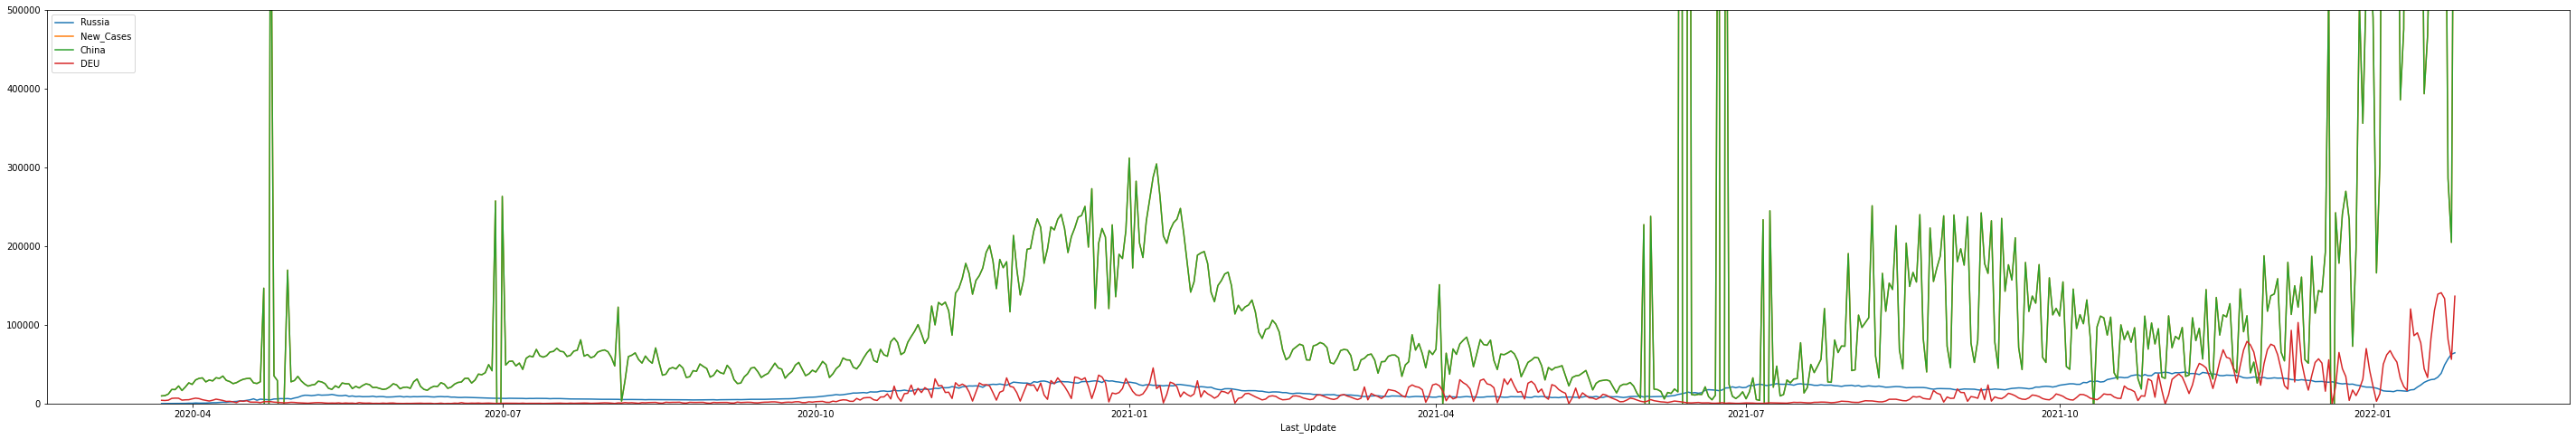

In [61]:
russia_new_cases = data.loc[data['Country_Region'] == 'Russia', 'New_Cases']
us_new_cases = data.loc[data['Country_Region'] == 'US', 'New_Cases']
germany_new_cases = data.loc[data['Country_Region'] == 'Germany', 'New_Cases']
china_new_cases = data.loc[data['Country_Region'].apply(lambda x: 'China' in x), 'New_Cases']

plt.figure(figsize=(50, 8))
plt.gca().set_ylim((0, 500000))
russia_new_cases.plot(label='Russia');
us_new_cases.plot();
us_new_cases.plot(label='China');
germany_new_cases.plot(label='DEU');
plt.legend(loc='upper left');
plt.show();


In [48]:
china_cases

Last_Update
2020-03-08     20632.0
2020-03-12       279.0
2020-03-13       266.0
2020-03-14     12471.0
2020-03-16      3815.0
                ...   
2022-01-21    118470.0
2022-01-22    118544.0
2022-01-23    118616.0
2022-01-24    118773.0
2022-01-25    118888.0
Name: Confirmed, Length: 684, dtype: float64

In [ ]:
data[data['Country_Region'].isin(['Afghanistan', 'Albania'])]

,Country_Region,Confirmed,New_Cases
Last_Update,,,


In [ ]:
# display(data)
def add_new_cases(data):

    temp_df, df_ = pd.DataFrame(), pd.DataFrame()
    for country in data['Country_Region'].unique():
        temp_df = data.loc[data['Country_Region'] == country, :].copy()
        temp_df['New_Cases'] = (temp_df['Confirmed'] - temp_df['Confirmed'].shift(1))
        df_ = pd.concat([df_, temp_df], axis=0).dropna()
    
    return df_


In [ ]:
any(data['Confirmed'].isna())

False

In [ ]:
def df_nans_calc(df):
    valid_se = (~df.isna()).sum(axis=0)
    df_nans = pd.concat([valid_se, df.shape[0] - valid_se], axis=1)
    df_nans.columns = ['valid', 'NaNs']
    return df_nans

df_nans_calc(data)

,valid,NaNs
Unnamed: 0,2637010,0
FIPS,2163669,473341
Admin2,2167116,469894
Province_State,2510659,126351
Country_Region,2637010,0
Last_Update,2637010,0
Lat,2571664,65346
Long_,2571664,65346
Confirmed,2636982,28
Deaths,2636576,434


In [ ]:
df['Country_Region'] = merge_columns('Country_Region', 'Country/Region', df).isna().sum()
pd.isna(df['Country_Region']).sum()

0